# Zee Recommender Systems
## Problem Statement :

- Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

## About the Dataset
- We are provided with the information of customers purchasing items from an online platform in Brazil.
- The database contains following files:
    - zee-ratings.dat
    - zee-users.dat
    - zee-movies.dat

## Concepts Tested:
- Recommender Engine
- Collaborative Filtering (Item-based & User-based Approach)
- Pearson Correlation
- Nearest Neighbors using Cosine Similarity
- Matrix Factorization

# Analysing basic metrics

In [1]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

--2024-03-27 17:12:31--  https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89817099 (86M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  85.66M   127MB/s    in 0.7s    

2024-03-27 17:12:32 (127 MB/s) - ‘mini.sh’ saved [89817099/89817099]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::ptyprocess==0.7.0=pyhd3eb1b0_2
  - defaults/linux-64::frozenlist==1.4.0=py38h5eee18b_0
  - defaults/linux-64::chardet==3.0.4=py38_1003
  - defaults/linux-64:

In [2]:
!pip install recommenders

ImportError: libffi.so.6: cannot open shared object file: No such file or directory
thread '<unnamed>' panicked at 'Python API call failed', /croot/cryptography_1710350347627/_build_env/.cargo.Linux/registry/src/index.crates.io-6f17d22bba15001f/pyo3-0.20.3/src/err/mod.rs:788:5
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
Traceback (most recent call last):
  File "/usr/local/bin/pip", line 11, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.8/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/usr/local/lib/python3.8/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/usr/local/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_im

In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Loading a Dataset
movies = pd.read_fwf('/content/drive/MyDrive/ZEE-data/zee-movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('/content/drive/MyDrive/ZEE-data/zee-ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('/content/drive/MyDrive/ZEE-data/zee-users.dat', encoding='ISO-8859-1')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
print(f'Shape of Movies data : {movies.shape}')
print(f'Shape of Ratings data : {ratings.shape}')
print(f'Shape of Users data : {users.shape}')

Shape of Movies data : (3883, 3)
Shape of Ratings data : (1000209, 1)
Shape of Users data : (6040, 1)


In [7]:
movies.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [8]:
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [9]:
users.head()

,UserID::Gender::Age::Occupation::Zip-code
0,1::F::1::10::48067
1,2::M::56::16::70072
2,3::M::25::15::55117
3,4::M::45::7::02460
4,5::M::25::20::55455


### **Cleaning Data**
#### Movies

In [10]:
#creating Clean DataFrame for Movies Data
movies = pd.DataFrame(movies['Movie ID::Title::Genres'].copy(deep = True))
movies['movieID'] = movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[0]).astype('int')
movies['title'] = movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[1])
movies['genres'] = movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[-1])
movies.drop(columns = ['Movie ID::Title::Genres'], inplace = True)
movies.drop_duplicates(keep='last', inplace = True)

In [11]:
#Replacing incomplete words in Genre Columns
movies['genres'].replace({ 'Acti$' : 'Action',
                          'Adv$' : 'Adventure', 'Advent$' : 'Adventure', 'Adventu$' : 'Adventure', 'Adventur$' : 'Adventure',
                          'Animati$' : 'Animation', 'Chi$' : 'Children', 'Chil$' : 'Children', 'Childr$' : 'Children',
                          'Childre$' : 'Children', 'Com$' : 'Comedy', 'Come$' : 'Comedy', 'Comed$' : 'Comedy',
                          'Docu$' : 'Documentary', 'Documen$' : 'Documentary', 'Document$' : 'Documentary',
                          'Documenta$' : 'Documentary', 'Dr$' : 'Drama', 'Dram$' : 'Drama', 'Fant$' : 'Fantasy',
                          'Fantas$' : 'Fantasy', 'Horr$' : 'Horror', 'Horro$' : 'Horror', 'Music$' : 'Musical',
                          'Ro$' : 'Romance', 'Rom$' : 'Romance', 'Roma$' : 'Romance', 'Roman$' : 'Romance', 'Sci$' : 'Sci-Fi',
                          'Sci-$' : 'Sci-Fi', 'Sci-F$' : 'Sci-Fi', 'Thri$' : 'Thriller', 'Thrille$' : 'Thriller', 'Wa$' : 'War',
                          'We$' : 'Western', 'Wester$' : 'Western'}, regex=True, inplace = True)
movies['genres'].replace({"Children's" : "Children", "Children'": "Children", "Sci-Fi" : "SciFi",
                          "Film-Noir": "FilmNoir" }, regex=True, inplace = True)
movies['genres'] = movies['genres'].str.lower()

In [12]:
movies.head()

,movieID,title,genres
0,1,Toy Story (1995),animation|children|comedy
1,2,Jumanji (1995),adventure|children|fantasy
2,3,Grumpier Old Men (1995),comedy|romance
3,4,Waiting to Exhale (1995),comedy|drama
4,5,Father of the Bride Part II (1995),comedy


#### Ratings

In [13]:
#creating Clean DataFrame for ratings Data
delimiter ="::"

ratings = ratings["UserID::MovieID::Rating::Timestamp"].str.split(delimiter,expand = True)
ratings.columns = ["UserID","MovieID","Rating","Timestamp"]

In [14]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [15]:
ratings['Rating'] = ratings['Rating'].astype('float')

#### Users

In [16]:
#creating Clean DataFrame for Users Data
delimiter ="::"

users = users["UserID::Gender::Age::Occupation::Zip-code"].str.split(delimiter,expand = True)
users.columns = ["UserID","Gender","Age","Occupation","Zip-code"]


In [17]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [18]:
occupation_mapping = {

    0: "other/na",

    1: "academic/educator",

    2: "artist",

    3: "clerical/admin",

    4: "college/grad student",

    5: "customer service",

    6: "doctor/health care",

    7: "executive/managerial",

    8: "farmer",

    9: "homemaker",

    10: "K-12 student",

    11: "lawyer",

    12: "programmer",

    13: "retired",

    14: "sales/marketing",

    15: "scientist",

    16: "self-employed",

    17: "technician/engineer",

    18: "tradesman/craftsman",

    19: "unemployed",

    20: "writer"
}

age_mapping = {

    1: "Under 18",

    18: "18-24",

    25: "25-34",

    35: "35-44",

    45: "45-49",

    50: "50-55",

    56: "56+"

}
users['Age'] = users['Age'].astype(int).map(age_mapping)
users['Occupation'] = users['Occupation'].astype(int).replace(occupation_mapping)

## **Checking Missing Value**

In [19]:
movies.isna().sum()

movieID    0
title      0
genres     0
dtype: int64

In [20]:
ratings.isna().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [21]:
users.isna().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [22]:
users.dtypes

UserID        object
Gender        object
Age           object
Occupation    object
Zip-code      object
dtype: object

## **Exploratory Data Analysis**
#### **Add New features Release Year**

In [23]:
movies['Release Year'] = movies['title'].str.extract('(.)\s*\((.\d+)', expand=True).iloc[:,1]

In [24]:
movies.head()

,movieID,title,genres,Release Year
0,1,Toy Story (1995),animation|children|comedy,1995
1,2,Jumanji (1995),adventure|children|fantasy,1995
2,3,Grumpier Old Men (1995),comedy|romance,1995
3,4,Waiting to Exhale (1995),comedy|drama,1995
4,5,Father of the Bride Part II (1995),comedy,1995


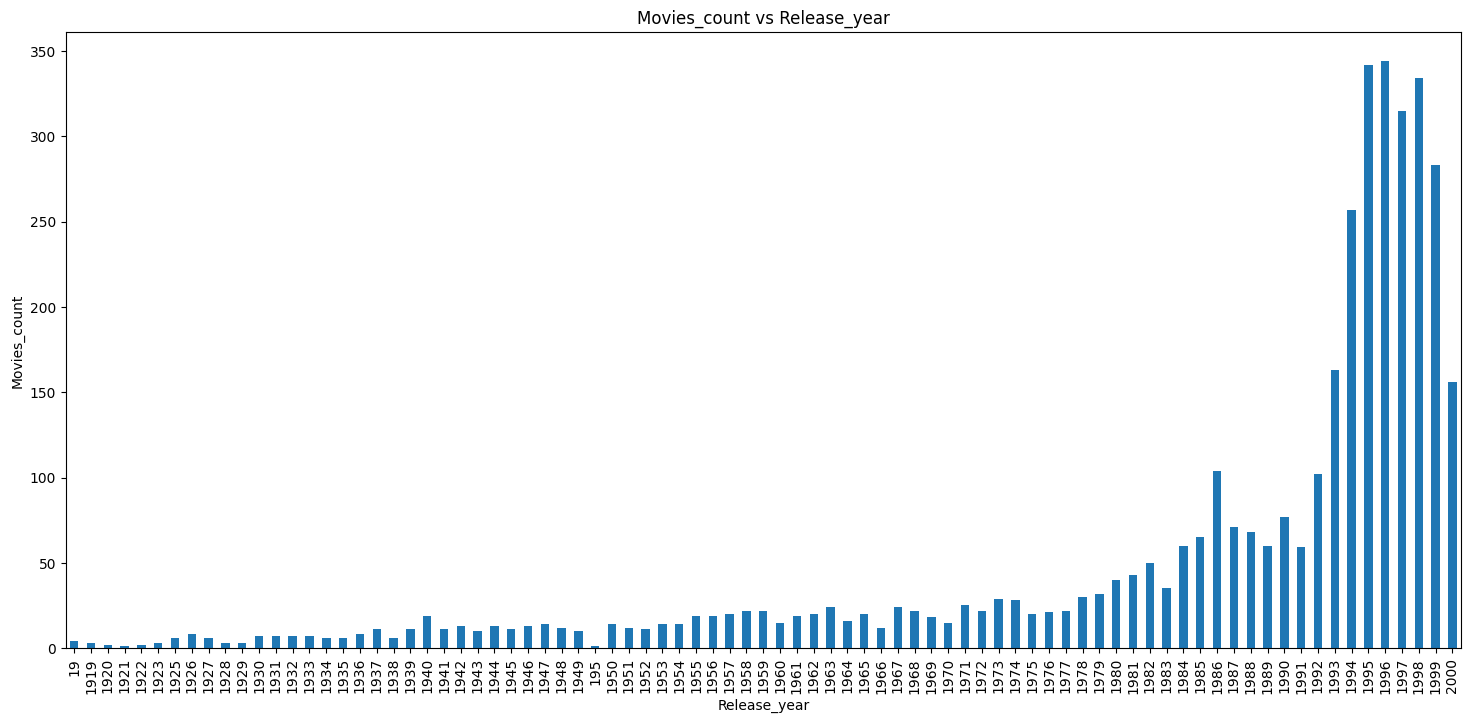

In [25]:
ax = plt.figure(figsize=(18,8))
movies.groupby('Release Year').count()['movieID'].plot(kind='bar')
plt.xlabel('Release_year')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Release_year')
plt.show()

## **Movie Count by Genre**

In [26]:
movie_genre = movies[['title', 'genres']].copy(deep = True)
movie_genre = movie_genre.assign(genres  = movie_genre['genres'].str.split('|')).explode('genres')
movie_genre.genres = movie_genre.genres.str.strip()

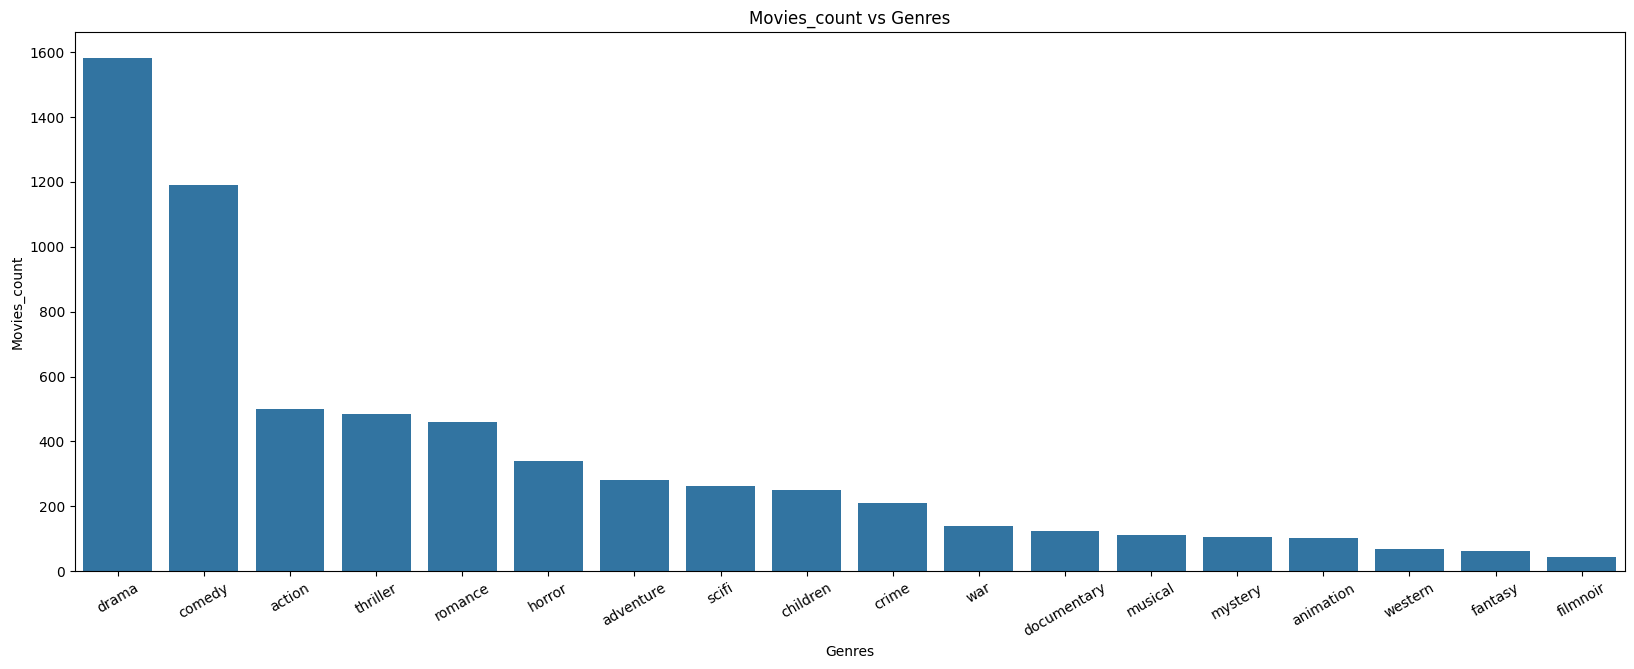

In [27]:
plt.figure(figsize=(20,7))
x = movie_genre.genres.value_counts().index
y = movie_genre.genres.value_counts().values
sns.barplot(x=x[:18], y=y[:18])
plt.xticks(rotation=30)
plt.xlabel('Genres')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Genres')
plt.show()

In [28]:
movies['movieID'] = movies['movieID'].astype('int')

In [29]:
ratings['MovieID'] = ratings['MovieID'].astype('int')

In [30]:
df_movies_ratings = ratings.merge(movies, how = 'inner', left_on = 'MovieID', right_on='movieID')

In [31]:
df_movies_ratings.head()

,UserID,MovieID,Rating,Timestamp,movieID,title,genres,Release Year
0,1,1193,5.0,978300760,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
1,2,1193,5.0,978298413,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
2,12,1193,4.0,978220179,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
3,15,1193,4.0,978199279,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
4,17,1193,5.0,978158471,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975


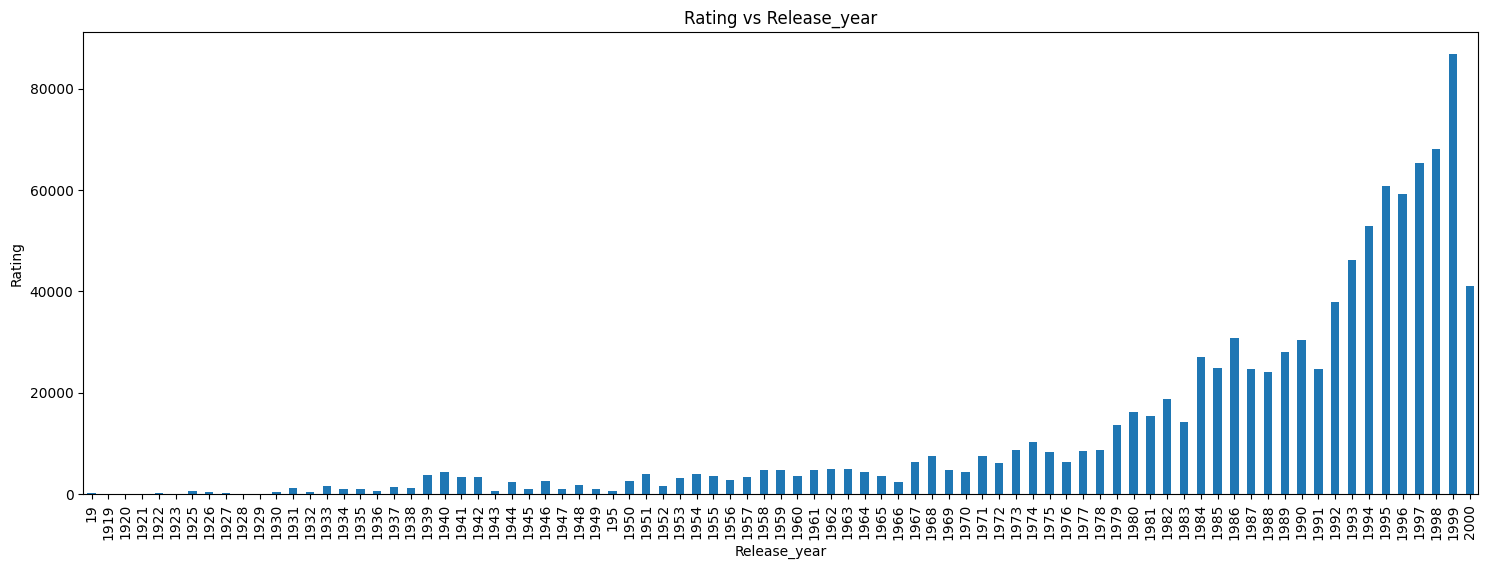

In [32]:
ax = plt.figure(figsize=(18,6))
df_movies_ratings.groupby('Release Year').count()['Rating'].replace(np.inf, -1).plot(kind='bar')
plt.xlabel('Release_year')
plt.ylabel('Rating')
plt.title('Rating vs Release_year')
plt.show()

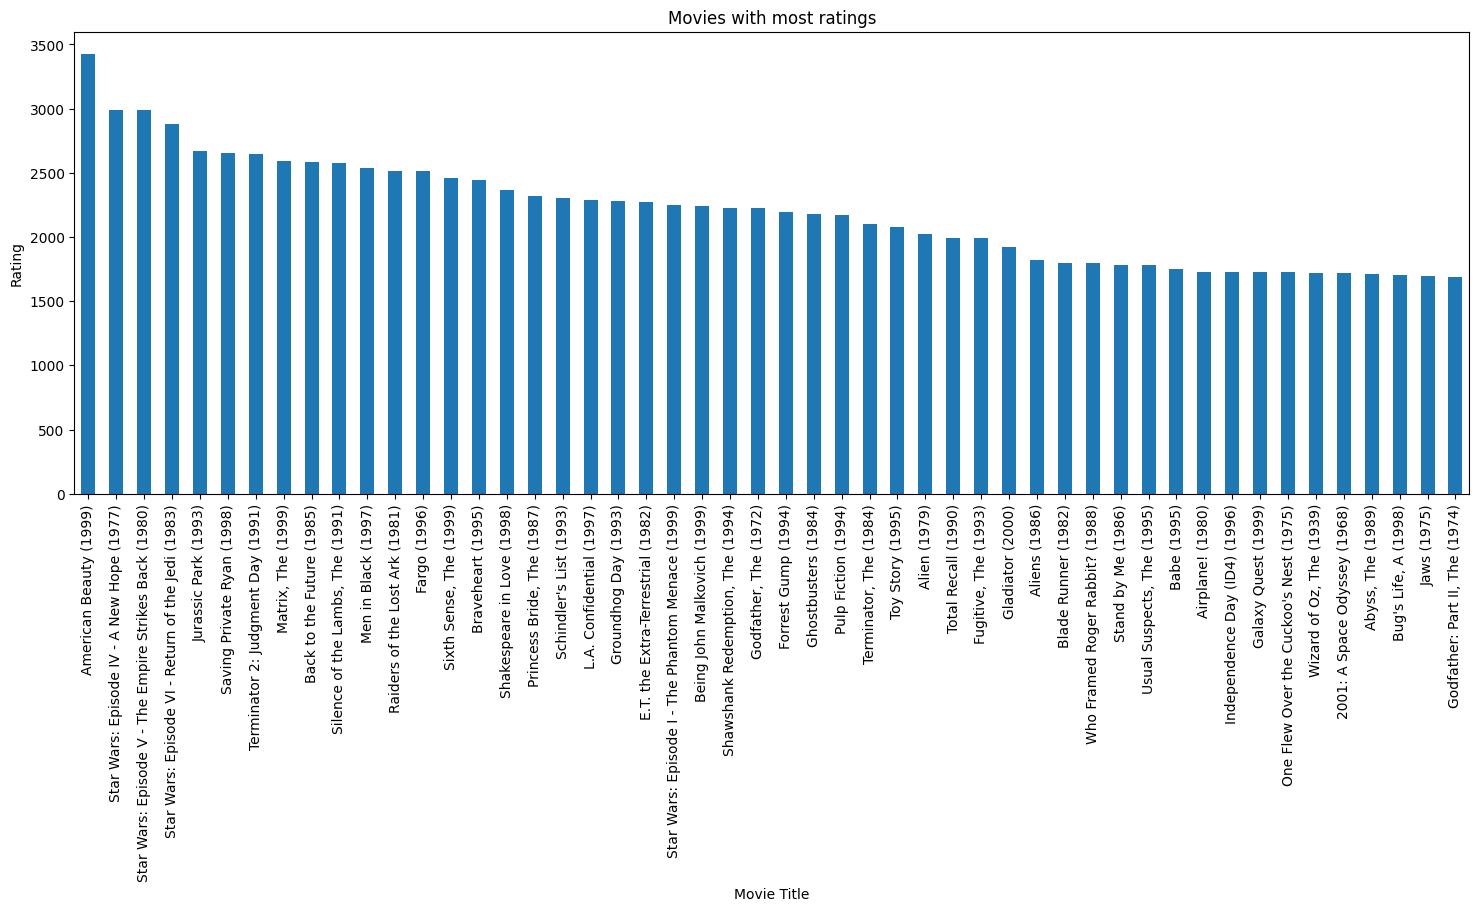

In [33]:
ax = plt.figure(figsize=(18,6))
df_movies_ratings.groupby('title').count().sort_values('Rating',ascending=False)['Rating'].head(50).plot(kind='bar')
plt.xlabel('Movie Title')
plt.ylabel('Rating')
plt.title('Movies with most ratings')
plt.show()

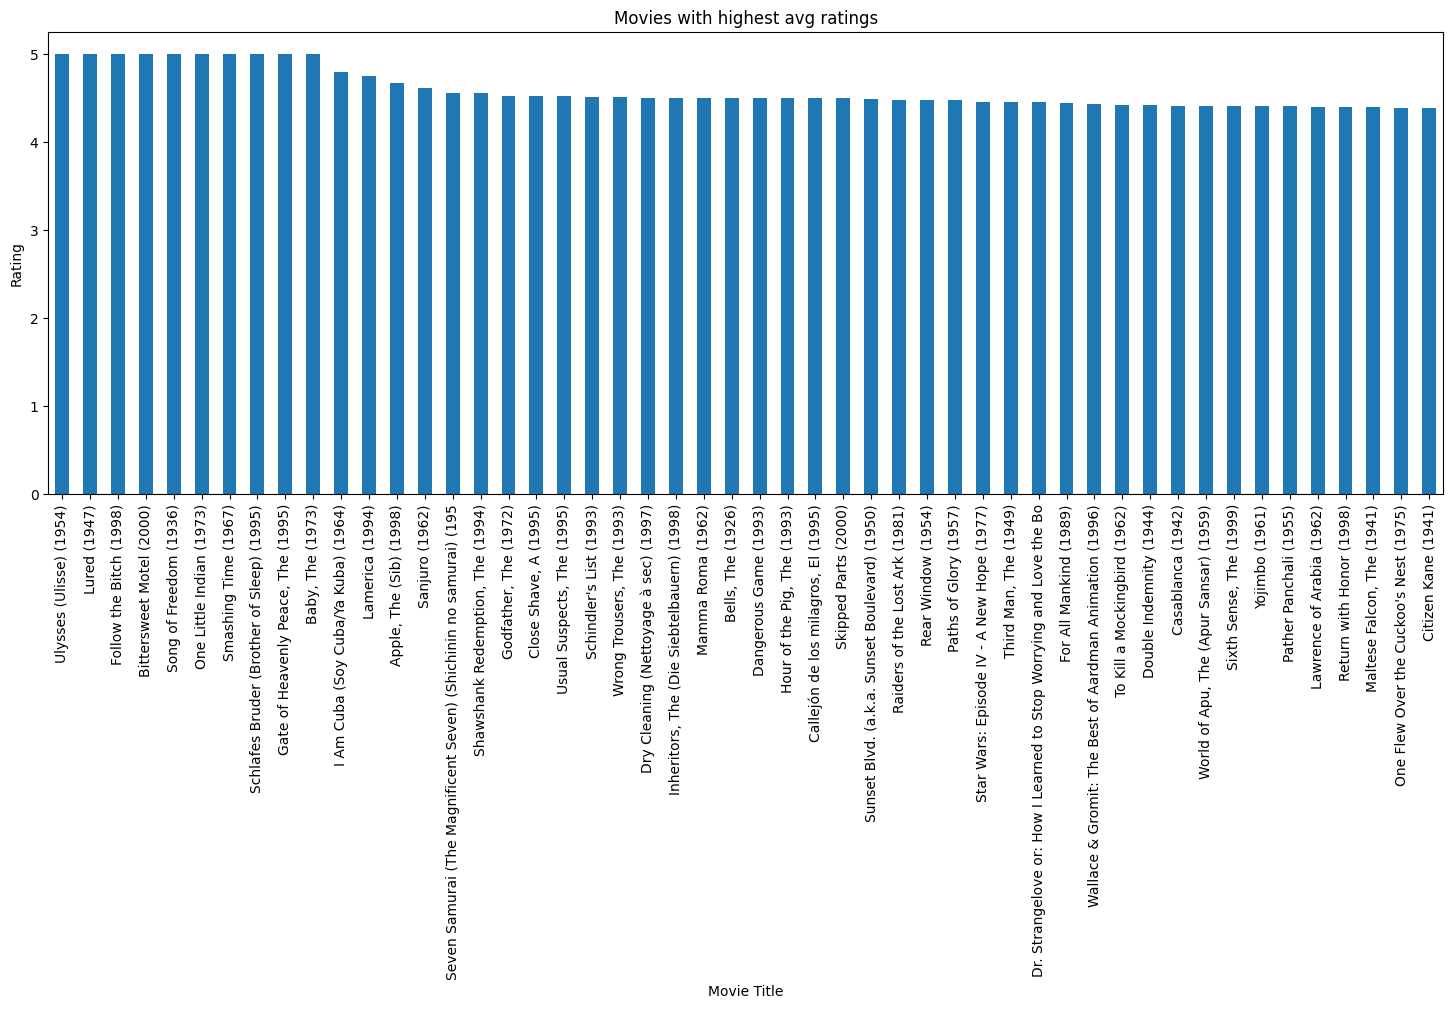

In [34]:
ax = plt.figure(figsize=(18,6))
df_movies_ratings.groupby('title').mean().sort_values('Rating',ascending=False)['Rating'].head(50).plot(kind='bar')
plt.xlabel('Movie Title')
plt.ylabel('Rating')
plt.title('Movies with highest avg ratings')
plt.show()

In [36]:
data_pivot_rating = pd.pivot_table(df_movies_ratings, index = 'title', values='Rating', aggfunc = ['count', 'mean']).round(5)
data_pivot_rating.columns = ['_'.join(col).strip() for col in data_pivot_rating.columns.values]
data_pivot_rating.sort_values(by =['count_Rating', 'mean_Rating'], ascending=False, inplace = True)

In [37]:
##Top 10 Most rated Movies & their average Rating
data_pivot_rating.head(10)

,count_Rating,mean_Rating
title,,
American Beauty (1999),3428,4.31739
Star Wars: Episode IV - A New Hope (1977),2991,4.45369
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.29298
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.02289
Jurassic Park (1993),2672,3.76385
Saving Private Ryan (1998),2653,4.33735
Terminator 2: Judgment Day (1991),2649,4.05851
"Matrix, The (1999)",2590,4.31583
Back to the Future (1985),2583,3.99032


In [38]:
df_movies_ratings['Release Year']=df_movies_ratings['Release Year'].fillna(0).astype('int32')

bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']

df_movies_ratings["Released_In"] =  pd.cut(df_movies_ratings['Release Year'].astype('int32'), bins=bins, labels=labels)

In [39]:
movies_per_decade = df_movies_ratings[['MovieID','Released_In']].groupby('Released_In').nunique()
movies_per_decade["% of all Movies"] = (movies_per_decade["MovieID"]/(df_movies_ratings["MovieID"].nunique())) * 100
movies_per_decade

,MovieID,% of all Movies
Released_In,,
20s,23,0.620615
30s,71,1.915812
40s,120,3.237992
50s,164,4.425256
60s,186,5.018888
70s,237,6.395035
80s,590,15.920130
90s,2298,62.007555


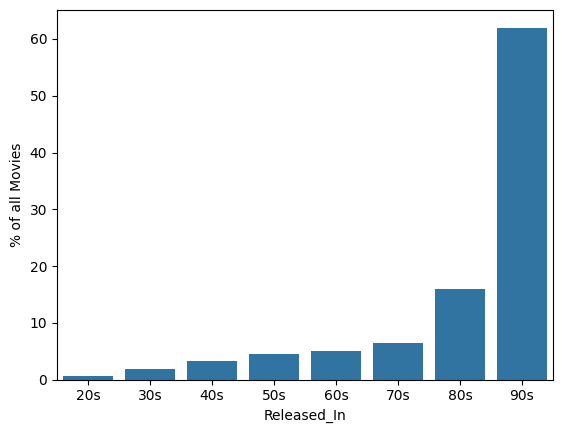

In [40]:
sns.barplot(x = movies_per_decade.index,
            y = movies_per_decade["% of all Movies"])
plt.show()

## **EDA on Users**

In [41]:
df_users_ratings = ratings.merge(users,on='UserID')

In [42]:
df_users_ratings.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,1193,5.0,978300760,F,Under 18,K-12 student,48067
1,1,661,3.0,978302109,F,Under 18,K-12 student,48067
2,1,914,3.0,978301968,F,Under 18,K-12 student,48067
3,1,3408,4.0,978300275,F,Under 18,K-12 student,48067
4,1,2355,5.0,978824291,F,Under 18,K-12 student,48067


In [43]:
# unique value emp_title column(listed in %)
gender = df_users_ratings['Gender'].value_counts(normalize=True).map(lambda calc: round(100*calc,2)).reset_index()
gender.columns = ['Gender', 'Count']
gender

,Gender,Count
0,M,75.36
1,F,24.64


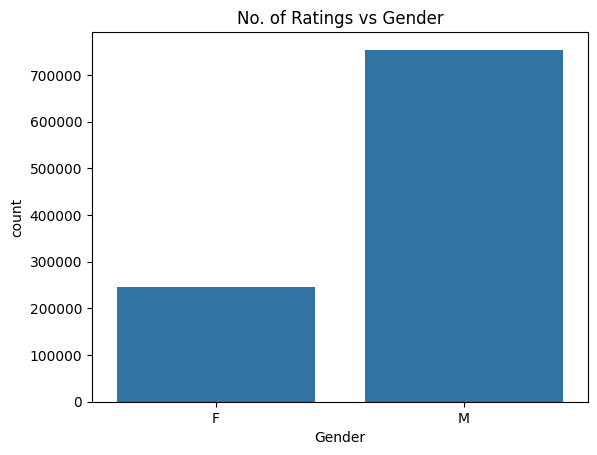

In [44]:
#no of rating and gender
sns.countplot(x = "Gender" , data = df_users_ratings)
plt.title("No. of Ratings vs Gender")
plt.show()

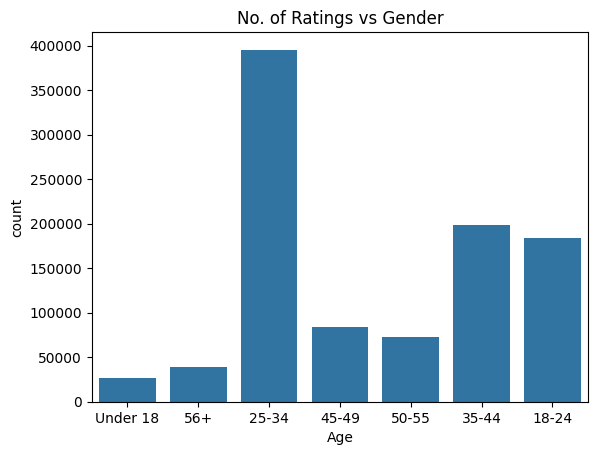

In [45]:
#no of rating and gender
sns.countplot(x = "Age" , data = df_users_ratings)
plt.title("No. of Ratings vs Gender")
plt.show()

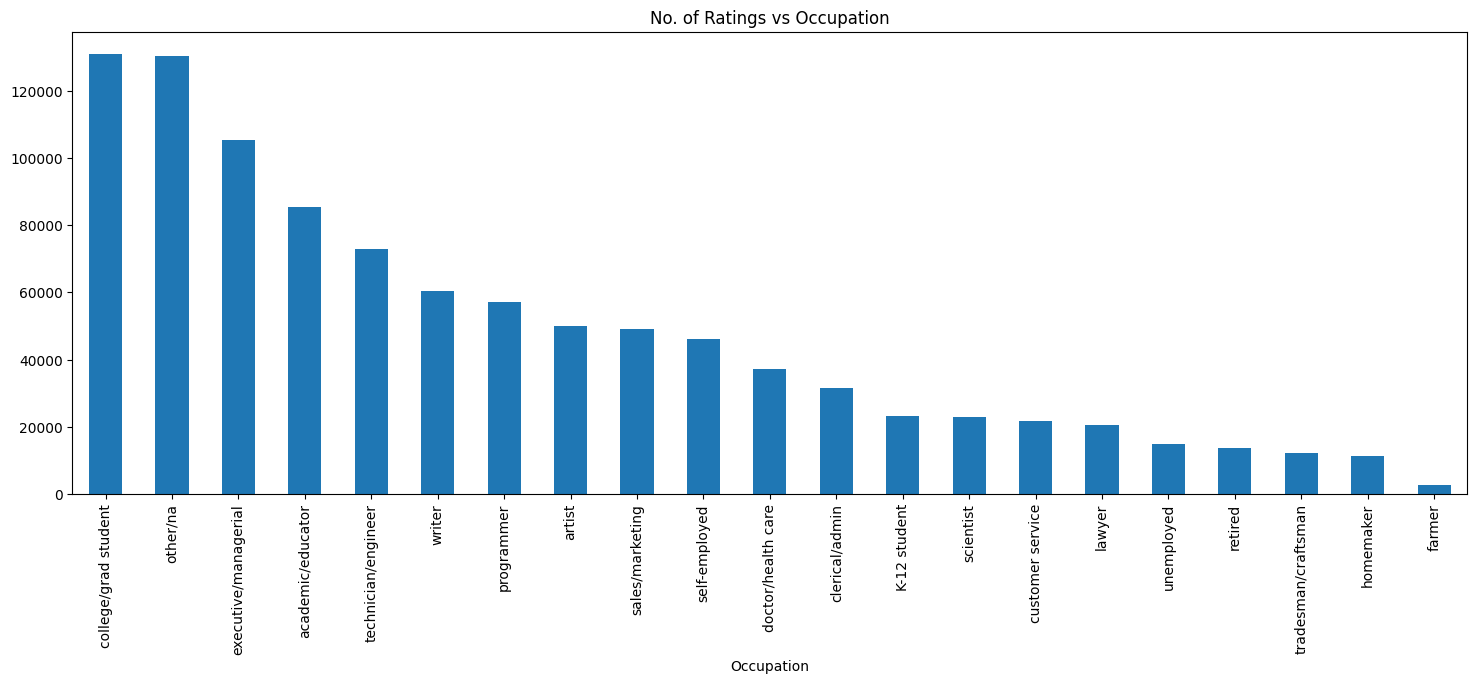

In [46]:
ax = plt.figure(figsize=(18,6))
df_users_ratings.groupby('Occupation').count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Occupation")
plt.show()

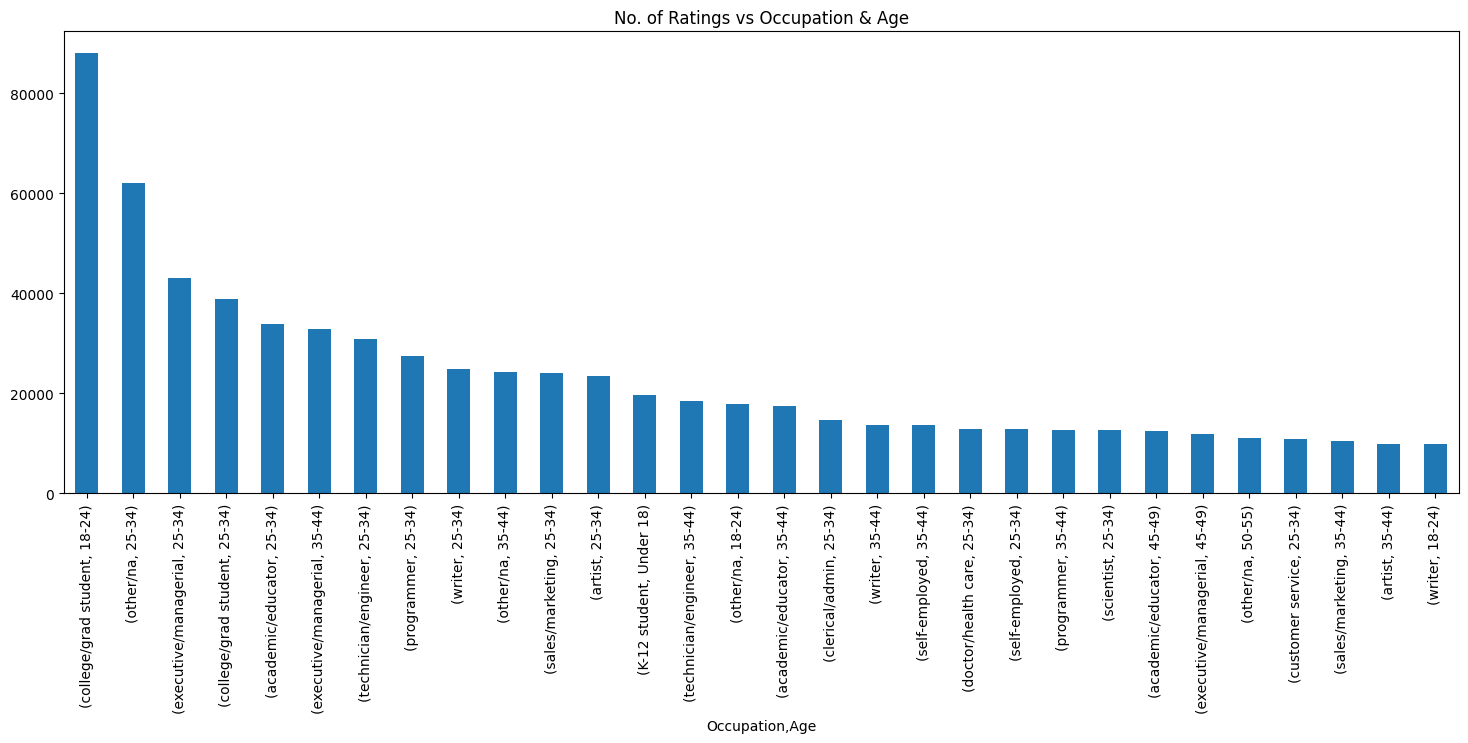

In [47]:
ax = plt.figure(figsize=(18,6))
df_users_ratings.groupby(['Occupation','Age']).count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Occupation & Age")
plt.show()

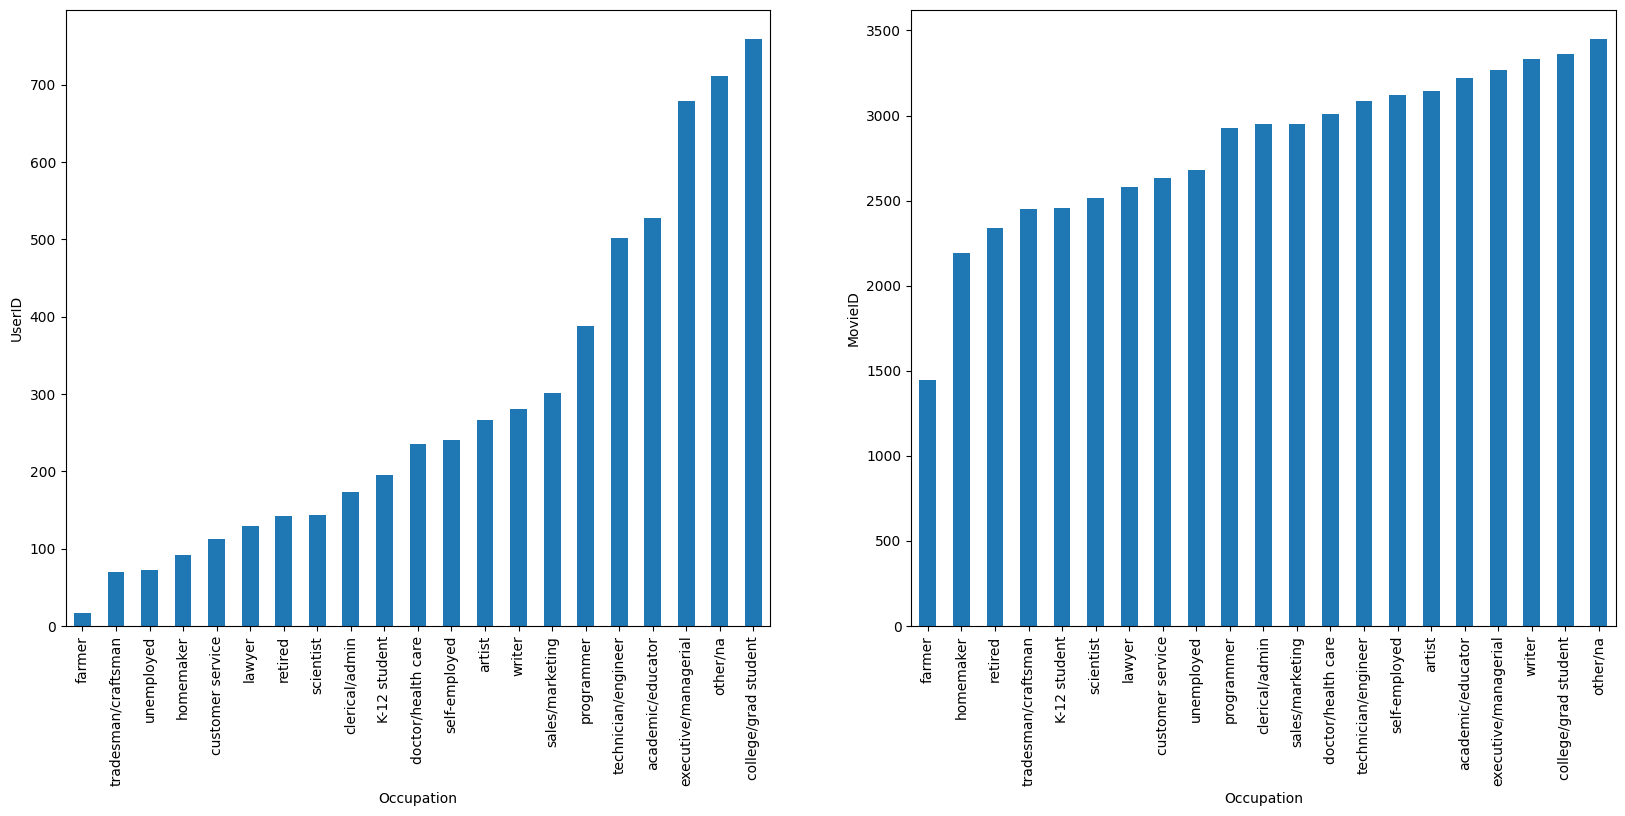

In [48]:
plt.rcParams["figure.figsize"] = (20,8)

plt.subplot(121)
df_users_ratings.groupby("Occupation")["UserID"].nunique().sort_values().plot(kind="bar")
plt.xlabel('Occupation')
plt.ylabel('UserID')
plt.subplot(122)
df_users_ratings.groupby("Occupation")["MovieID"].nunique().sort_values().plot(kind="bar")
plt.xlabel('Occupation')
plt.ylabel('MovieID')
plt.show()

- Majority of the Users are College Graduates and Students , followed by Executives, educators and engineers.
y of the Users are College Graduates and Students , followed by Executives, educators and engineers.
- Maximum movies are watched and rated by user's occupations are College graduate students , writers , executives, educator and artists.

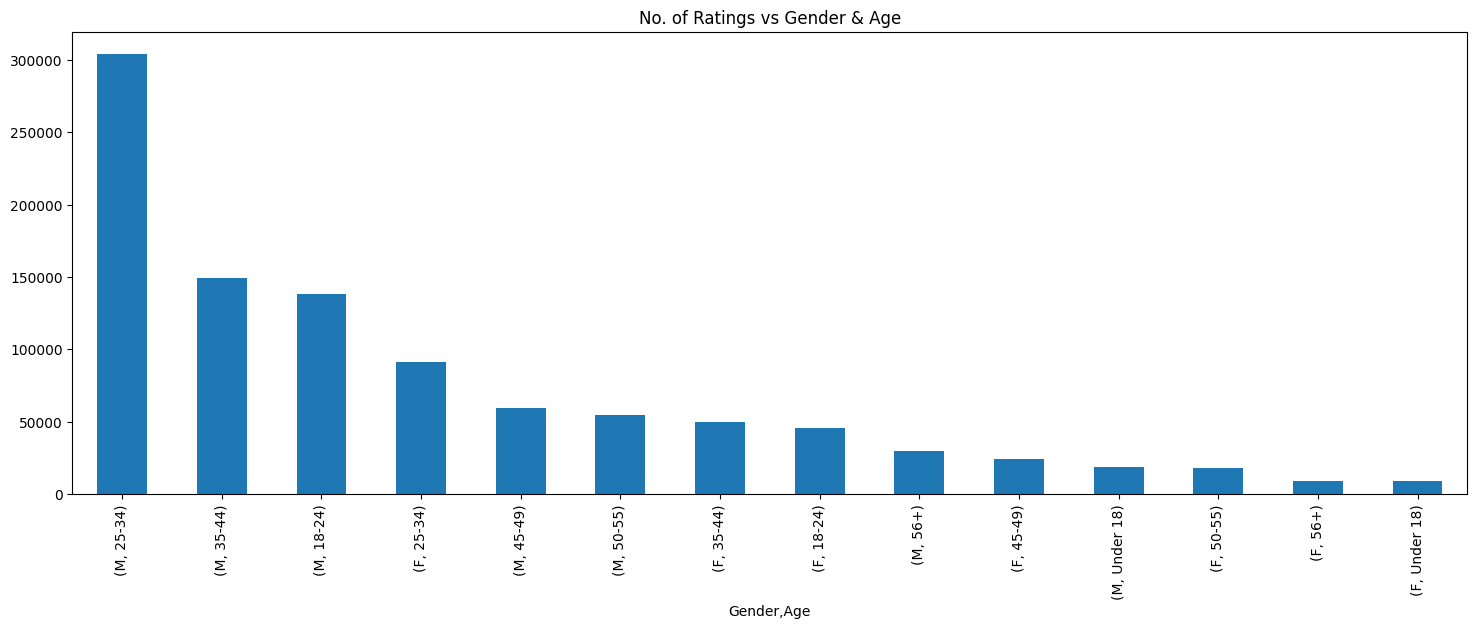

In [49]:
ax = plt.figure(figsize=(18,6))
df_users_ratings.groupby(['Gender','Age']).count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Gender & Age")
plt.show()

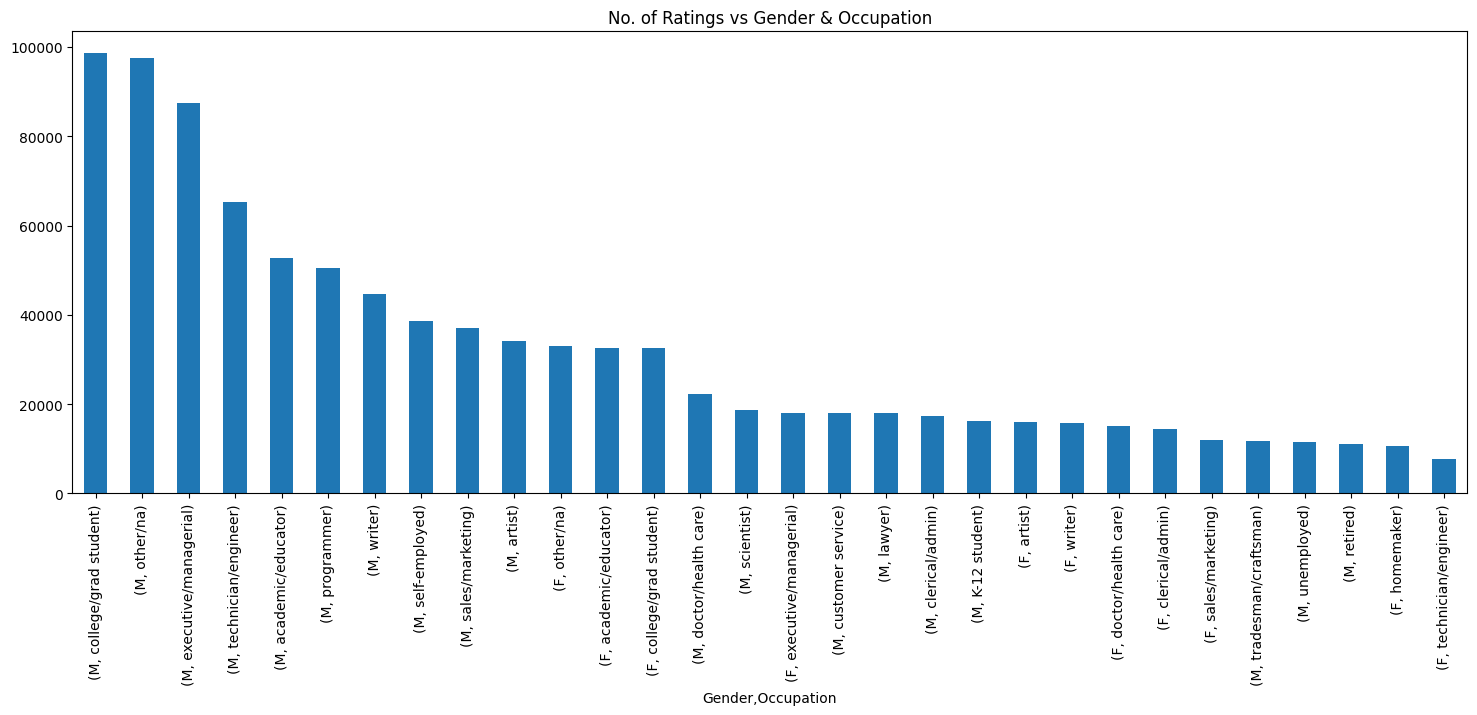

In [50]:
ax = plt.figure(figsize=(18,6))
df_users_ratings.groupby(['Gender','Occupation']).count().sort_values('Rating',ascending=False)['Rating'].head(30).plot(kind='bar')
plt.title("No. of Ratings vs Gender & Occupation")
plt.show()

**Insights**
1. Reviews given by males is more than 3 times as that of females, this means reviews might be biased towards one kind of users.
3. Most reviews are given by users between 25-34.
4. College students have highest number of reviews.
5. Females with age between 25-34 hv given most reviews amt females.

In [51]:
df_users_movies_ratings = df_users_ratings.merge(movies.reset_index(drop=True),left_on='MovieID',right_on=['movieID'])

In [52]:
df_users_movies_ratings.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,movieID,title,genres,Release Year
0,1,1193,5.0,978300760,F,Under 18,K-12 student,48067,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
1,2,1193,5.0,978298413,M,56+,self-employed,70072,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
2,12,1193,4.0,978220179,M,25-34,programmer,32793,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
3,15,1193,4.0,978199279,M,25-34,executive/managerial,22903,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975
4,17,1193,5.0,978158471,M,50-55,academic/educator,95350,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975


In [53]:
df_tmp = df_movies_ratings.groupby('title').count()['Rating'].reset_index()

In [55]:
movies_title = df_tmp[df_tmp['Rating'] >250]['title'].values

In [56]:
df_tmp = df_users_movies_ratings[df_users_movies_ratings['title'].isin(movies_title)].groupby(['title','Gender']).mean().sort_values('Rating',ascending=False)['Rating'].reset_index()
df_tmp

,title,Gender,Rating
0,"Close Shave, A (1995)",F,4.644444
1,"Wrong Trousers, The (1993)",F,4.588235
2,"Godfather, The (1972)",M,4.583333
3,Seven Samurai (The Magnificent Seven) (Shichin...,M,4.576628
4,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),F,4.572650
...,...,...,...
2423,Super Mario Bros. (1993),M,1.820339
2424,Grease 2 (1982),M,1.792553
2425,Battlefield Earth (2000),M,1.616949
2426,Barb Wire (1996),F,1.585366


In [57]:
df_tmp[df_tmp['Gender'] == 'M'].head()

,title,Gender,Rating
2,"Godfather, The (1972)",M,4.583333
3,Seven Samurai (The Magnificent Seven) (Shichin...,M,4.576628
7,"Shawshank Redemption, The (1994)",M,4.560625
11,Raiders of the Lost Ark (1981),M,4.520597
12,"Usual Suspects, The (1995)",M,4.518248


In [58]:
df_tmp[df_tmp['Gender'] == 'F'].head()

,title,Gender,Rating
0,"Close Shave, A (1995)",F,4.644444
1,"Wrong Trousers, The (1993)",F,4.588235
4,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),F,4.572650
5,Wallace & Gromit: The Best of Aardman Animatio...,F,4.563107
6,Schindler's List (1993),F,4.562602


### **Top rated movies Occupation wise**

In [59]:
df_tmp = df_users_movies_ratings[df_users_movies_ratings['title'].isin(movies_title)].groupby(['title','Occupation']).mean().sort_values('Rating',ascending=False)['Rating'].reset_index()

In [60]:
for i in occupation_mapping.values():
    print('Top Movies liked by: ',i)
    display(df_tmp[df_tmp['Occupation']==i].head(5))
    print()

Top Movies liked by:  other/na


,title,Occupation,Rating
251,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),other/na,4.671642
413,M (1931),other/na,4.600000
491,"Third Man, The (1949)",other/na,4.571429
524,Wallace & Gromit: The Best of Aardman Animatio...,other/na,4.553191
535,"Shawshank Redemption, The (1994)",other/na,4.547170



Top Movies liked by:  academic/educator


,title,Occupation,Rating
319,Seven Samurai (The Magnificent Seven) (Shichin...,academic/educator,4.649351
382,"Maltese Falcon, The (1941)",academic/educator,4.608696
503,"Usual Suspects, The (1995)",academic/educator,4.561644
504,Schindler's List (1993),academic/educator,4.561086
562,"Wrong Trousers, The (1993)",academic/educator,4.535211



Top Movies liked by:  artist


,title,Occupation,Rating
218,"Manchurian Candidate, The (1962)",artist,4.727273
220,"Close Shave, A (1995)",artist,4.722222
355,When We Were Kings (1996),artist,4.625000
361,Rear Window (1954),artist,4.618182
376,Seven Samurai (The Magnificent Seven) (Shichin...,artist,4.611111



Top Movies liked by:  clerical/admin


,title,Occupation,Rating
178,Modern Times (1936),clerical/admin,4.800000
188,Raise the Red Lantern (1991),clerical/admin,4.800000
219,Rear Window (1954),clerical/admin,4.725000
333,"Maltese Falcon, The (1941)",clerical/admin,4.636364
368,Top Hat (1935),clerical/admin,4.615385



Top Movies liked by:  college/grad student


,title,Occupation,Rating
245,"Shawshank Redemption, The (1994)",college/grad student,4.683582
250,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),college/grad student,4.675676
320,"Usual Suspects, The (1995)",college/grad student,4.649123
422,"Close Shave, A (1995)",college/grad student,4.595506
509,"Godfather, The (1972)",college/grad student,4.556364



Top Movies liked by:  customer service


,title,Occupation,Rating
58,Shallow Grave (1994),customer service,5.00
101,"Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",customer service,5.00
128,My Life as a Dog (Mitt liv som hund) (1985),customer service,5.00
203,Laura (1944),customer service,4.75
211,Modern Times (1936),customer service,4.75



Top Movies liked by:  doctor/health care


,title,Occupation,Rating
229,"Shawshank Redemption, The (1994)",doctor/health care,4.711340
230,Schindler's List (1993),doctor/health care,4.705263
239,Henry V (1989),doctor/health care,4.692308
242,To Kill a Mockingbird (1962),doctor/health care,4.690476
282,Pecker (1998),doctor/health care,4.666667



Top Movies liked by:  executive/managerial


,title,Occupation,Rating
248,"Wrong Trousers, The (1993)",executive/managerial,4.677966
383,"Godfather, The (1972)",executive/managerial,4.607914
455,"Shawshank Redemption, The (1994)",executive/managerial,4.576419
545,Seven Samurai (The Magnificent Seven) (Shichin...,executive/managerial,4.542857
551,"Usual Suspects, The (1995)",executive/managerial,4.539267



Top Movies liked by:  farmer


,title,Occupation,Rating
2,Like Water for Chocolate (Como agua para choco...,farmer,5.0
3,"South Park: Bigger, Longer and Uncut (1999)",farmer,5.0
4,Bullets Over Broadway (1994),farmer,5.0
5,Bedknobs and Broomsticks (1971),farmer,5.0
9,Hamlet (1996),farmer,5.0



Top Movies liked by:  homemaker


,title,Occupation,Rating
15,54 (1998),homemaker,5.0
22,"Wrong Trousers, The (1993)",homemaker,5.0
47,Bottle Rocket (1996),homemaker,5.0
51,Inherit the Wind (1960),homemaker,5.0
64,For a Few Dollars More (1965),homemaker,5.0



Top Movies liked by:  K-12 student


,title,Occupation,Rating
0,"'burbs, The (1989)",K-12 student,5.0
7,Somewhere in Time (1980),K-12 student,5.0
18,Breaking the Waves (1996),K-12 student,5.0
19,All About My Mother (Todo Sobre Mi Madre) (1999),K-12 student,5.0
29,Real Genius (1985),K-12 student,5.0



Top Movies liked by:  lawyer


,title,Occupation,Rating
165,Casablanca (1942),lawyer,4.866667
167,When We Were Kings (1996),lawyer,4.833333
184,"Princess Mononoke, The (Mononoke Hime) (1997)",lawyer,4.800000
249,To Kill a Mockingbird (1962),lawyer,4.677419
281,Seven Samurai (The Magnificent Seven) (Shichin...,lawyer,4.666667



Top Movies liked by:  programmer


,title,Occupation,Rating
194,Bringing Up Baby (1938),programmer,4.785714
196,Seven Samurai (The Magnificent Seven) (Shichin...,programmer,4.763158
309,Henry V (1989),programmer,4.666667
358,Star Wars: Episode IV - A New Hope (1977),programmer,4.619266
367,High Noon (1952),programmer,4.615385



Top Movies liked by:  retired


,title,Occupation,Rating
1,Rising Sun (1993),retired,5.0
40,Charlotte's Web (1973),retired,5.0
41,"Wrong Trousers, The (1993)",retired,5.0
45,Bottle Rocket (1996),retired,5.0
49,Six Degrees of Separation (1993),retired,5.0



Top Movies liked by:  sales/marketing


,title,Occupation,Rating
189,All About Eve (1950),sales/marketing,4.800000
215,"Close Shave, A (1995)",sales/marketing,4.739130
222,City Lights (1931),sales/marketing,4.714286
237,"Shawshank Redemption, The (1994)",sales/marketing,4.696429
240,M (1931),sales/marketing,4.692308



Top Movies liked by:  scientist


,title,Occupation,Rating
149,Guess Who's Coming to Dinner (1967),scientist,5.000000
162,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),scientist,5.000000
170,Midnight Express (1978),scientist,4.833333
200,Roman Holiday (1953),scientist,4.750000
210,Modern Times (1936),scientist,4.750000



Top Movies liked by:  self-employed


,title,Occupation,Rating
173,Double Indemnity (1944),self-employed,4.807692
195,"Bicycle Thief, The (Ladri di biciclette) (1948)",self-employed,4.777778
204,City Lights (1931),self-employed,4.750000
238,All Quiet on the Western Front (1930),self-employed,4.692308
284,Seven Samurai (The Magnificent Seven) (Shichin...,self-employed,4.666667



Top Movies liked by:  technician/engineer


,title,Occupation,Rating
232,Wallace & Gromit: The Best of Aardman Animatio...,technician/engineer,4.700000
234,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),technician/engineer,4.700000
332,"Treasure of the Sierra Madre, The (1948)",technician/engineer,4.640000
338,Raiders of the Lost Ark (1981),technician/engineer,4.633803
357,"Shawshank Redemption, The (1994)",technician/engineer,4.620253



Top Movies liked by:  tradesman/craftsman


,title,Occupation,Rating
6,"Last Picture Show, The (1971)",tradesman/craftsman,5.0
11,"Last Emperor, The (1987)",tradesman/craftsman,5.0
13,Fear and Loathing in Las Vegas (1998),tradesman/craftsman,5.0
54,Fried Green Tomatoes (1991),tradesman/craftsman,5.0
73,"Bicycle Thief, The (Ladri di biciclette) (1948)",tradesman/craftsman,5.0



Top Movies liked by:  unemployed


,title,Occupation,Rating
8,Being There (1979),unemployed,5.0
30,City Lights (1931),unemployed,5.0
48,Inherit the Wind (1960),unemployed,5.0
87,From Here to Eternity (1953),unemployed,5.0
100,"Thomas Crown Affair, The (1968)",unemployed,5.0



Top Movies liked by:  writer


,title,Occupation,Rating
341,To Kill a Mockingbird (1962),writer,4.629630
342,"Godfather, The (1972)",writer,4.629310
381,Casablanca (1942),writer,4.608696
435,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),writer,4.585366
446,Singin' in the Rain (1952),writer,4.580000


### **Top rated movies Age group wise**

In [61]:
df_tmp = df_users_movies_ratings[df_users_movies_ratings['title'].isin(movies_title)].groupby(['title','Age']).mean().sort_values('Rating',ascending=False)['Rating'].reset_index()

In [62]:
for i in age_mapping.values():
    print('Top Movies liked by age group: ',i)
    display(df_tmp[df_tmp['Age']==i].head(5))
    print()

Top Movies liked by age group:  Under 18


,title,Age,Rating
2,Shadowlands (1993),Under 18,5.0
3,Night Shift (1982),Under 18,5.0
4,Somewhere in Time (1980),Under 18,5.0
5,"Thin Blue Line, The (1988)",Under 18,5.0
6,Breaking the Waves (1996),Under 18,5.0



Top Movies liked by age group:  18-24


,title,Age,Rating
20,"Usual Suspects, The (1995)",18-24,4.680798
22,"Shawshank Redemption, The (1994)",18-24,4.674569
48,Seven Samurai (The Magnificent Seven) (Shichin...,18-24,4.604938
69,"Close Shave, A (1995)",18-24,4.568000
78,Life Is Beautiful (La Vita è bella) (1997),18-24,4.549180



Top Movies liked by age group:  25-34


,title,Age,Rating
57,"Shawshank Redemption, The (1994)",25-34,4.587699
62,Raiders of the Lost Ark (1981),25-34,4.578521
63,"Godfather, The (1972)",25-34,4.574051
66,Star Wars: Episode IV - A New Hope (1977),25-34,4.572695
74,"Usual Suspects, The (1995)",25-34,4.552430



Top Movies liked by age group:  35-44


,title,Age,Rating
45,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),35-44,4.611570
58,To Kill a Mockingbird (1962),35-44,4.585859
60,City Lights (1931),35-44,4.581818
83,"Godfather, The (1972)",35-44,4.541935
89,Seven Samurai (The Magnificent Seven) (Shichin...,35-44,4.532895



Top Movies liked by age group:  45-49


,title,Age,Rating
33,"Wrong Trousers, The (1993)",45-49,4.647059
36,"Bicycle Thief, The (Ladri di biciclette) (1948)",45-49,4.636364
47,"Close Shave, A (1995)",45-49,4.607143
56,Schindler's List (1993),45-49,4.591549
85,Seven Samurai (The Magnificent Seven) (Shichin...,45-49,4.541667



Top Movies liked by age group:  50-55


,title,Age,Rating
18,Real Genius (1985),50-55,4.714286
31,"Wrong Trousers, The (1993)",50-55,4.660000
32,Seven Samurai (The Magnificent Seven) (Shichin...,50-55,4.657143
46,Wallace & Gromit: The Best of Aardman Animatio...,50-55,4.611111
54,"Maltese Falcon, The (1941)",50-55,4.594595



Top Movies liked by age group:  56+


,title,Age,Rating
0,Better Off Dead... (1985),56+,5.000000
1,Creature Comforts (1990),56+,5.000000
16,"Wrong Trousers, The (1993)",56+,4.722222
28,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",56+,4.666667
37,Inherit the Wind (1960),56+,4.625000


## **Creating pivot**

In [63]:
ratings['UserID'] = ratings['UserID'].astype('int')
ratings['MovieID'] = ratings['MovieID'].astype('int')

In [64]:
df_pivot = pd.pivot_table(ratings,columns=['MovieID'],index=['UserID'],values=['Rating']).droplevel(0, axis=1)

## **Adding columns for movies with no ratings**

In [65]:
for col in list(set(movies['movieID']) - set(df_pivot.columns)):
    df_pivot[col] = np.nan

## **Imputaion of NaNs with column mean**

In [66]:
fill_mean = lambda col : col.fillna(col.mean())

df_impute_col = df_pivot.apply(fill_mean, axis = 0).dropna(axis=1)

In [67]:
df_impute_col.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
3,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
4,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
5,4.146846,3.201141,3.016736,2.729412,3.006757,2.000000,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


## **Imputaion of NaNs with row mean**

In [68]:
fill_mean = lambda col : col.fillna(col.mean())

df_impute_row = df_pivot.apply(fill_mean, axis = 1)

In [69]:
df_impute_row.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3558,3560,1001,3561,2030,2547,1524,3059,3582,3583
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,...,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679
2,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,...,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178
3,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,...,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961
4,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,...,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476
5,3.146465,3.146465,3.146465,3.146465,3.146465,2.000000,3.146465,3.146465,3.146465,3.146465,...,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465


In [70]:
ratings['MovieID'].nunique(),ratings['UserID'].nunique()

(3706, 6040)

## **Recommendations based on pearson correlation**

In [71]:
from scipy.stats.stats import pearsonr

In [72]:
def get_movie_recommend_pearson(name,ratings):
    movie_id = int(movies[movies['title'] == name]['movieID'].iloc[0])
    kj = ratings[movie_id].values
    moviesa = [(i,pearsonr(kj,ratings[i].values)) for i in ratings.columns]
    moviesa.sort(key=lambda x:x[1],reverse=True )
    movies.index = movies['movieID']
    return movies.loc[[i[0] for i in moviesa[1:6]]].reset_index(drop=True)

In [73]:
name = 'Shawshank Redemption, The (1994)'
##based on rowise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_row)

,movieID,title,genres,Release Year
0,1704,Good Will Hunting (1997),drama,1997
1,508,Philadelphia (1993),drama,1993
2,1412,Some Mother's Son (1996),drama,1996
3,2610,Three Seasons (1999),drama,1999
4,428,"Bronx Tale, A (1993)",drama,1993


In [74]:
##based on columnwise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_col)

,movieID,title,genres,Release Year
0,527,Schindler's List (1993),drama|war,1993
1,508,Philadelphia (1993),drama,1993
2,593,"Silence of the Lambs, The (1991)",drama|thriller,1991
3,50,"Usual Suspects, The (1995)",crime|thriller,1995
4,590,Dances with Wolves (1990),adventure|drama|western,1990


In [75]:
name = "Mortal Kombat (1995)"
##based on rowise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_row)

,movieID,title,genres,Release Year
0,1930,Cavalcade (1933),drama,1933
1,591,Tough and Deadly (1995),action|drama|thriller,1995
2,1133,Talking About Sex (1994),comedy|drama,1994
3,2563,Beauty (1998),drama,1998
4,2172,"Strike! (a.k.a. All I Wanna Do, The Hairy Bird...",comedy,1998


In [76]:
##based on columnwise imputed utility matrix
get_movie_recommend_pearson(name,df_impute_col)

,movieID,title,genres,Release Year
0,504,No Escape (1994),action|scifi,1994
1,20,Money Train (1995),action,1995
2,511,"Program, The (1993)",action|drama,1993
3,10,GoldenEye (1995),action|adventure|thriller,1995
4,519,Robocop 3 (1993),scifi|thriller,1993


## **Sparse matrix**

In [77]:
from scipy.sparse import csr_matrix
sparse_matrix = csr_matrix(df_pivot, dtype=np.int8)
sparse_matrix

<6040x3883 sparse matrix of type '<class 'numpy.int8'>'
	with 23453320 stored elements in Compressed Sparse Row format>

In [78]:
sparse_matrix.toarray()

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]], dtype=int8)

## **Cosine similarity**

In [79]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [80]:
user_similarity = csr_matrix(pairwise_distances(df_impute_row,metric='cosine'))
item_similarity = csr_matrix(pairwise_distances(df_impute_row.T,metric='cosine'))

## **User similarity Matrix & Item similarity Matrix**

In [81]:
user_similarity.toarray()

array([[0.00000000e+00, 1.34354932e-03, 6.04245475e-04, ...,
        3.83706122e-04, 7.26988712e-04, 4.89307708e-03],
       [1.34354932e-03, 0.00000000e+00, 1.57337210e-03, ...,
        1.41648619e-03, 1.70031377e-03, 5.94890693e-03],
       [6.04245475e-04, 1.57337210e-03, 2.10942375e-14, ...,
        5.89723881e-04, 9.20491910e-04, 5.25109678e-03],
       ...,
       [3.83706122e-04, 1.41648619e-03, 5.89723881e-04, ...,
        4.13002965e-14, 7.34670860e-04, 5.00992253e-03],
       [7.26988712e-04, 1.70031377e-03, 9.20491910e-04, ...,
        7.34670860e-04, 7.03881398e-14, 5.08961030e-03],
       [4.89307708e-03, 5.94890693e-03, 5.25109678e-03, ...,
        5.00992253e-03, 5.08961030e-03, 6.21724894e-14]])

In [82]:
item_similarity.toarray()

array([[0.00000000e+00, 1.34969396e-02, 1.31515739e-02, ...,
        9.32620932e-03, 9.32620932e-03, 9.32620932e-03],
       [1.34969396e-02, 0.00000000e+00, 7.37480782e-03, ...,
        3.94678789e-03, 3.94678789e-03, 3.94678789e-03],
       [1.31515739e-02, 7.37480782e-03, 3.33066907e-16, ...,
        3.50986594e-03, 3.50986594e-03, 3.50986594e-03],
       ...,
       [9.32620932e-03, 3.94678789e-03, 3.50986594e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.32620932e-03, 3.94678789e-03, 3.50986594e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.32620932e-03, 3.94678789e-03, 3.50986594e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [83]:
movies.index = movies['movieID'].astype(int)

In [84]:
df_impute_row

MovieID,1,2,3,4,5,6,7,8,9,10,...,3558,3560,1001,3561,2030,2547,1524,3059,3582,3583
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,...,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679,4.188679
2,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,...,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178,3.713178
3,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,...,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961,3.901961
4,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,...,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476,4.190476
5,3.146465,3.146465,3.146465,3.146465,3.146465,2.000000,3.146465,3.146465,3.146465,3.146465,...,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465,3.146465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.302928,3.302928,3.302928,2.000000,3.302928,3.000000,3.302928,3.302928,3.302928,3.302928,...,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928,3.302928
6037,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,...,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822,3.717822
6038,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,...,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000,3.800000


In [85]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine')
knn.fit(df_impute_row.T.values)
distances, indices = knn.kneighbors(df_impute_row.T, n_neighbors=6)

In [86]:
def get_recommendations_cosine(name):
    movie_id = int(movies[movies['title'] == name]['movieID'].iloc[0])

    moviesind = indices[movie_id,:]
    display(movies.loc[moviesind[1:]])

In [87]:
name = 'Alice in Wonderland (1951)'
get_recommendations_cosine(name)

,movieID,title,genres,Release Year
movieID,,,,
901,901,Funny Face (1957),comedy|musical,1957
553,553,Tombstone (1993),western,1993
3284,3284,They Might Be Giants (1971),comedy|romance,1971
3289,3289,Not One Less (Yi ge dou bu neng shao) (1999),drama,1999
2850,2850,Public Access (1993),drama|thriller,1993


In [88]:
name = 'Misérables, Les (1995)'
get_recommendations_cosine(name)

,movieID,title,genres,Release Year
movieID,,,,
57,57,Home for the Holidays (1995),drama,1995
3859,3859,"Eyes of Tammy Faye, The (2000)",documentary,2000
3754,3754,"Adventures of Rocky and Bullwinkle, The (2000)",animation|children,2000
3841,3841,Air America (1990),action|comedy,1990
3730,3730,"Conversation, The (1974)",drama|mystery,1974


## **Matrix Factorization**

In [89]:
ratings['UserID'] = ratings['UserID'].astype('int')
ratings['MovieID'] = ratings['MovieID'].astype('int')
ratings['Rating'] = ratings['Rating'].astype('float')
# ratings['UserID'] = ratings['UserID'].astype('int')

In [90]:
split = np.random.rand(len(ratings)) < 0.8
train = ratings[split]
valid = ratings[~split]
print(train.shape , valid.shape)

(800629, 4) (199580, 4)


In [91]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers import dot
from keras.models import Model


from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsolutePercentageError

In [92]:
n_movies=ratings['MovieID'].max() +1
n_users=len(ratings['UserID'].unique())+1
n_latent_factors=10  # hyperparamter to deal with.

In [93]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec =Flatten(name='FlattenUsers')(user_embedding)

In [94]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)

In [95]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, movie_input],sim)

In [96]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse',metrics=[MeanSquaredError(), RootMeanSquaredError(), MeanAbsolutePercentageError(), ])


train.shape
batch_size=128
epochs=10

History = model.fit([train['UserID'],train['MovieID']],train.Rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid['UserID'],valid['MovieID']],valid.Rating),
                              verbose = 1)


Epoch 1/10
6255/6255 [==============================] - 24s 4ms/step - loss: 5.0052 - mean_squared_error: 5.0052 - root_mean_squared_error: 2.2372 - mean_absolute_percentage_error: 51.5806 - val_loss: 1.1208 - val_mean_squared_error: 1.1208 - val_root_mean_squared_error: 1.0587 - val_mean_absolute_percentage_error: 29.9644
Epoch 2/10
6255/6255 [==============================] - 21s 3ms/step - loss: 0.9393 - mean_squared_error: 0.9393 - root_mean_squared_error: 0.9692 - mean_absolute_percentage_error: 28.8228 - val_loss: 0.8814 - val_mean_squared_error: 0.8814 - val_root_mean_squared_error: 0.9389 - val_mean_absolute_percentage_error: 28.5795
Epoch 3/10
6255/6255 [==============================] - 23s 4ms/step - loss: 0.8617 - mean_squared_error: 0.8617 - root_mean_squared_error: 0.9283 - mean_absolute_percentage_error: 28.4230 - val_loss: 0.8636 - val_mean_squared_error: 0.8636 - val_root_mean_squared_error: 0.9293 - val_mean_absolute_percentage_error: 28.5670
Epoch 4/10
6255/6255 [===

In [97]:
model.save('/content/drive/MyDrive/ZEE-data/recommend-model.keras')

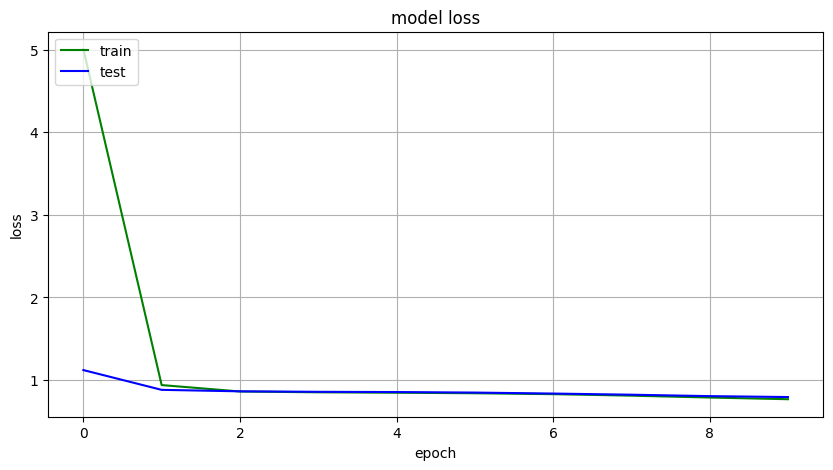

In [98]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

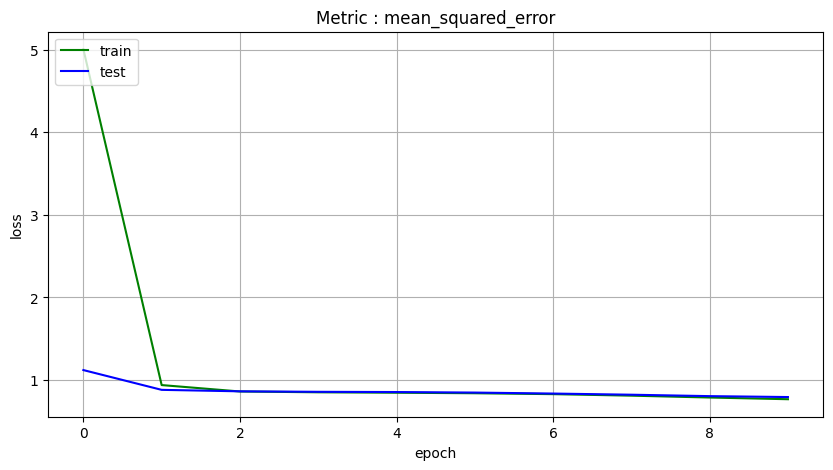

In [99]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['mean_squared_error'] , 'g')
plt.plot(History.history['val_mean_squared_error'] , 'b')
plt.title('Metric : mean_squared_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

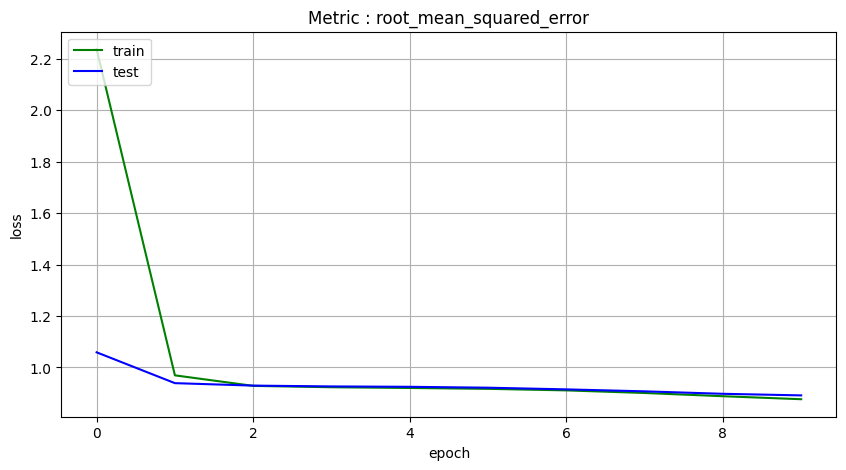

In [100]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['root_mean_squared_error'] , 'g')
plt.plot(History.history['val_root_mean_squared_error'] , 'b')
plt.title('Metric : root_mean_squared_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

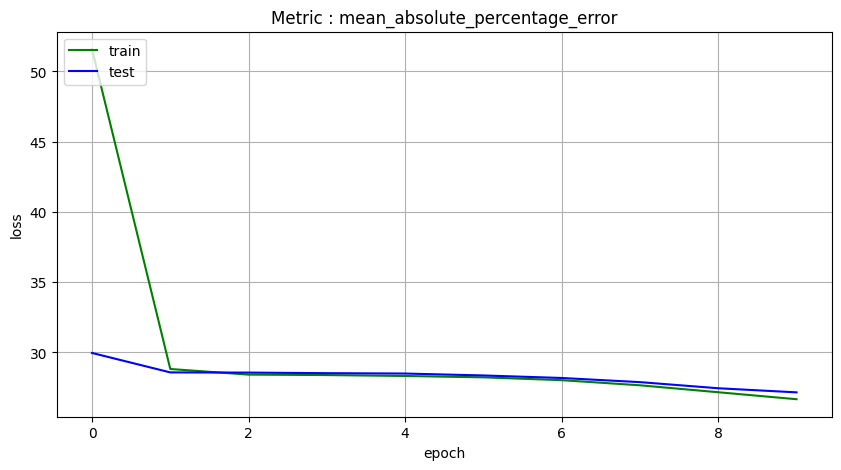

In [101]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['mean_absolute_percentage_error'] , 'g')
plt.plot(History.history['val_mean_absolute_percentage_error'] , 'b')
plt.title('Metric : mean_absolute_percentage_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [102]:
movie_embedding_learnt = model.get_layer(name='movie_embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9
count,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000,3953.000000
mean,-0.558650,0.574422,-0.581814,0.565434,0.582558,-0.567579,0.578050,0.601346,-0.614275,0.558334
std,0.268738,0.227734,0.240498,0.267446,0.232572,0.275858,0.225779,0.287622,0.293442,0.255961
min,-1.426999,-0.049973,-1.620981,-0.081482,-0.181511,-1.502283,-0.049924,-0.292634,-1.338227,-0.293577
25%,-0.747185,0.474500,-0.720583,0.385196,0.484790,-0.759040,0.482317,0.451286,-0.813967,0.399807
50%,-0.594017,0.611229,-0.607287,0.598187,0.616873,-0.587314,0.613315,0.623543,-0.667312,0.592154
75%,-0.381398,0.715912,-0.473330,0.755470,0.736310,-0.382602,0.723153,0.776681,-0.470935,0.739781
max,0.151297,1.365087,0.049572,1.332822,1.188273,0.125207,1.369109,1.767365,0.780736,1.345485


In [103]:
user_embedding_learnt = model.get_layer(name='user_embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2,3,4,5,6,7,8,9
count,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000
mean,-0.532375,0.531427,-0.540683,0.538263,0.510834,-0.530862,0.537740,0.513815,-0.498264,0.524818
std,0.105950,0.109069,0.132560,0.106542,0.137284,0.122312,0.091678,0.232873,0.242214,0.108507
min,-0.982579,-0.085033,-1.234940,-0.044923,-0.183098,-1.071444,-0.035412,-0.601535,-1.450740,-0.101384
25%,-0.599003,0.463367,-0.627426,0.474342,0.427120,-0.607032,0.481108,0.378492,-0.653247,0.460176
50%,-0.536355,0.532914,-0.547763,0.539548,0.515655,-0.533224,0.538819,0.520612,-0.507528,0.526854
75%,-0.471125,0.598913,-0.460865,0.603333,0.596235,-0.456806,0.597102,0.657800,-0.350759,0.594744
max,0.049260,1.133027,0.161055,1.200469,1.089184,0.507281,0.930872,1.439168,0.902666,0.963917


In [104]:
def recommend(user_id, number_of_movies=5):
    movi = np.dot(movie_embedding_learnt,user_embedding_learnt[user_id])
    mids = np.argpartition(movi, -number_of_movies)[-number_of_movies:]
    return movies.loc[mids]

In [105]:
recommend(user_id=1079)

,movieID,title,genres,Release Year
movieID,,,,
923,923,Citizen Kane (1941),drama,1941
2503,2503,"Apple, The (Sib) (1998)",drama,1998
527,527,Schindler's List (1993),drama|war,1993
858,858,"Godfather, The (1972)",action|crime|drama,1972
1193,1193,One Flew Over the Cuckoo's Nest (1975),drama,1975


## Questionnaire

1.Users of which age group have watched and rated the most number of movies

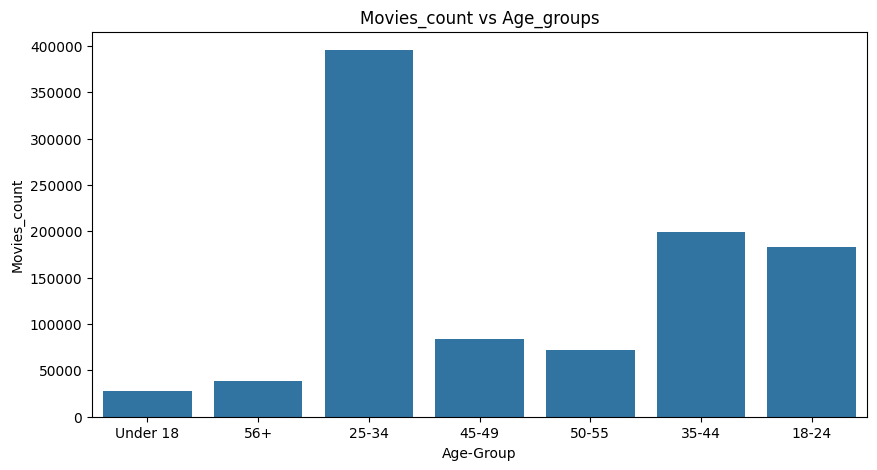

In [106]:
#no of rating and gender
sns.countplot(x = "Age" , data = df_users_ratings)
plt.xlabel('Age-Group')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Age_groups')
plt.show()


Users of age group 25-34 have watched and rated most number of movies followed by 35-44 and 18-24.

**2. Users belonging to which profession have watched and rated the most movies?**

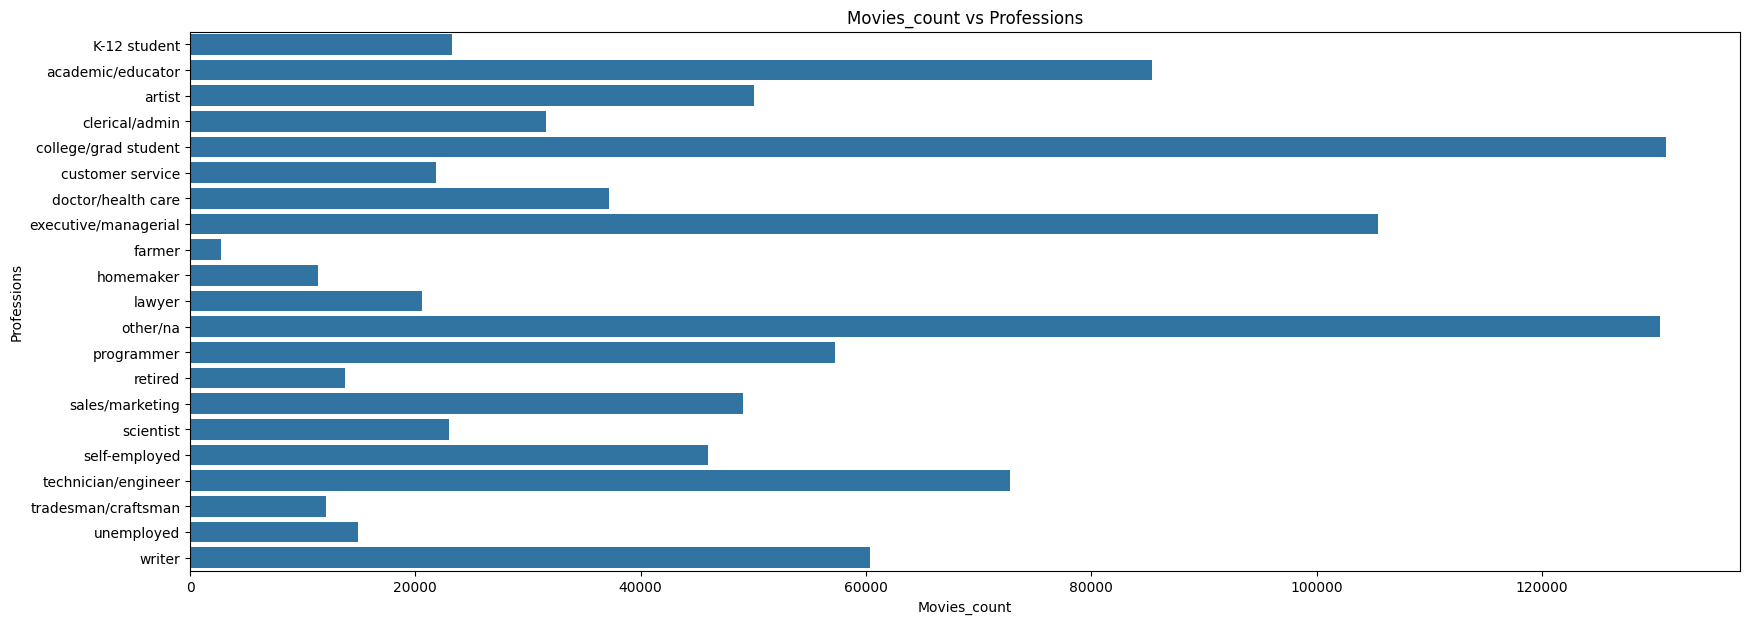

In [107]:
plt.figure(figsize=(20,7))
x = df_users_ratings.Occupation.value_counts().sort_index().index
y = df_users_ratings.Occupation.value_counts().sort_index().values
sns.barplot(x=y, y=x)
plt.xlabel('Movies_count')
plt.ylabel('Professions')
plt.title('Movies_count vs Professions')
plt.show()

Users of profession 4: "college/grad student" have watched and rated most number of movies followed by

0: "other" or not specified,

7: "executive/managerial" and

1: "academic/educator".

**3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)**

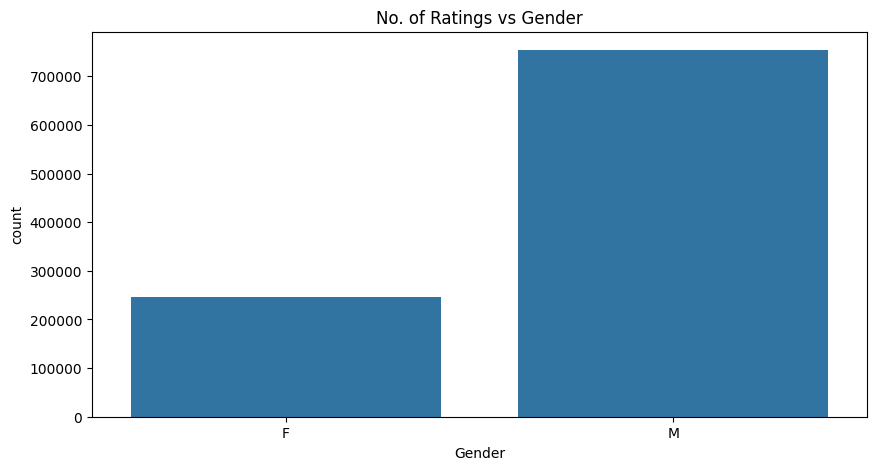

In [108]:
#no of rating and gender
sns.countplot(x = "Gender" , data = df_users_ratings)
plt.title("No. of Ratings vs Gender")
plt.show()

Out of all responses, 75% is Male. Hence the statement is True.

**4.	Most of the movies present in our dataset were released in which decade?**

a.	70s

b. 90s

c. 50s

d.80s

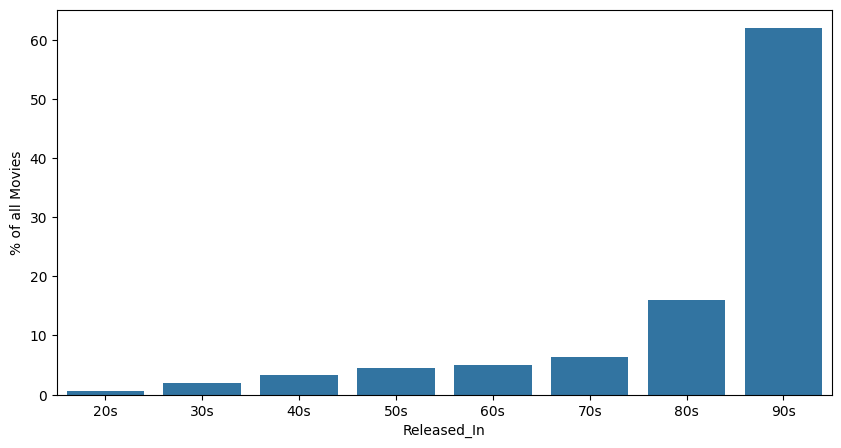

In [109]:
sns.barplot(x = movies_per_decade.index,
            y = movies_per_decade["% of all Movies"])
plt.show()

Most of the movies present in our dataset were released in Decade 90s

**5. The movie with maximum no. of ratings is**

In [110]:
data_pivot_rating.head(10)

,count_Rating,mean_Rating
title,,
American Beauty (1999),3428,4.31739
Star Wars: Episode IV - A New Hope (1977),2991,4.45369
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.29298
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.02289
Jurassic Park (1993),2672,3.76385
Saving Private Ryan (1998),2653,4.33735
Terminator 2: Judgment Day (1991),2649,4.05851
"Matrix, The (1999)",2590,4.31583
Back to the Future (1985),2583,3.99032


American Beauty (1999). Tope 5 are shown above.

**6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach**

In [111]:
name = 'Liar Liar (1997)'
get_recommendations_cosine(name)

,movieID,title,genres,Release Year
movieID,,,,
3262,3262,Twin Peaks: Fire Walk with Me (1992),drama|mystery,1992
3284,3284,They Might Be Giants (1971),comedy|romance,1971
669,669,Aparajito (1956),drama,1956
2850,2850,Public Access (1993),drama|thriller,1993
2017,2017,Babes in Toyland (1961),children|fantasy|musical,1961


**7.	On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.**

**User-based** (which measures the similarity between target users and other users)

&

**Item-based** (which measures the similarity between the items that target users rate or interact with and other items)


-----------------------------------------------

**8.	Pearson Correlation ranges between ____ & ____ whereas, Cosine Similarity belongs to the interval between ___ and ___ .**

=> Pearson Correlation ranges between **-1 to 1** whereas, Cosine Similarity belongs to the interval between **0 and 1**.

----------------------------------

**9.	Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.**


=> Model Performance 3 Folds CV: **Mean RMSE = 0.9100** and **Mean MAE = 0.7209**

----------------------------------


**10.	Give the sparse ‘row’ matrix representation for the following dense matrix -**

[ [1 0]

[3 7] ]


=> **Array representation:**

rows  =   [0, 1, 1 ]

columns = [0, 0, 1 ]

values =  [1, 3, 7 ]



**Linked List representation:**

[row, column, value, pointer_to_next_node]


[0, 0, 1 ] ---> [1, 0,, 3 ] ---> [1, 1, 7 ] (null)


-----------------------------------